In [41]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
fake = Faker()

In [7]:
def generate_transaction_data(num_samples=10000):
    """Generates base transaction dataset."""
    transactions = []
    
    for _ in range(num_samples):
        transaction_id = fake.uuid4()
        vendor_id = fake.uuid4()
        transaction_amount = round(random.uniform(100, 500000), 2)
        transaction_date = fake.date_between(start_date='-1y', end_date='today')
        vendor_onboard_date = fake.date_between(start_date='-5y', end_date=transaction_date)
        
        # Introduce random bank account changes (10% chance)
        vendor_bank_change_date = (vendor_onboard_date + timedelta(days=random.randint(1, 100))) \
                                 if random.random() < 0.1 else None
        
        payment_split_count = random.choice([1, 2, 3, 5, 10]) if transaction_amount > 10000 else 1
        approval_manager_role = random.choice(["Finance Manager", "Assistant Manager", "Unknown", "Intern"])
        
        transactions.append({
            "transaction_id": transaction_id,
            "vendor_id": vendor_id,
            "transaction_amount": transaction_amount,
            "transaction_date": transaction_date,
            "vendor_onboard_date": vendor_onboard_date,
            "vendor_bank_change_date": vendor_bank_change_date,
            "payment_split_count": payment_split_count,
            "approval_manager_role": approval_manager_role
        })
    
    df = pd.DataFrame(transactions)

    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    df['vendor_onboard_date'] = pd.to_datetime(df['vendor_onboard_date'])
    


    # Feature Engineering
    df['days_since_onboard'] = (df['transaction_date'] - df['vendor_onboard_date']).dt.days
    df['is_bank_changed_recently'] = df['vendor_bank_change_date'].notna().astype(int)
    df['high_value_transaction'] = (df['transaction_amount'] > 100000).astype(int)
    df['suspicious_split_payment'] = (df['payment_split_count'] > 3).astype(int)
    
    return df

In [8]:
dataset = generate_transaction_data()
dataset.head()

,transaction_id,vendor_id,transaction_amount,transaction_date,vendor_onboard_date,vendor_bank_change_date,payment_split_count,approval_manager_role,days_since_onboard,is_bank_changed_recently,high_value_transaction,suspicious_split_payment
0,6a7a891d-ac10-41b5-aafe-e37399cb56cc,31fe3574-6257-41c3-a865-e99abee54096,344214.39,2024-08-31,2023-08-21,2023-10-18,3,Intern,376,1,1,0
1,b617a84b-5f4c-4f39-bf90-b0075c9639c4,0fad6ea1-6483-409e-bfb0-c6efd276ef30,374268.83,2024-09-23,2022-02-20,None,1,Intern,946,0,1,0
2,ec58ea3a-49b6-4fb2-9533-65fbe88c18e9,a8910741-4bf3-4a5a-b6ba-4a56e5ff6379,470418.52,2024-07-01,2023-03-05,None,2,Unknown,484,0,1,0
3,49a36de0-38e6-4055-936b-7e2efffd754c,b9e1d9c3-f8dc-4e46-973e-391093981fc4,232530.79,2024-06-13,2021-07-29,2021-10-23,5,Intern,1050,1,1,1
4,86a0acfc-fc2b-4cc3-9e22-d12770bbbccc,35a608da-ee17-462a-aeb2-6917097bf798,462123.02,2025-03-02,2023-02-19,None,1,Unknown,742,0,1,0


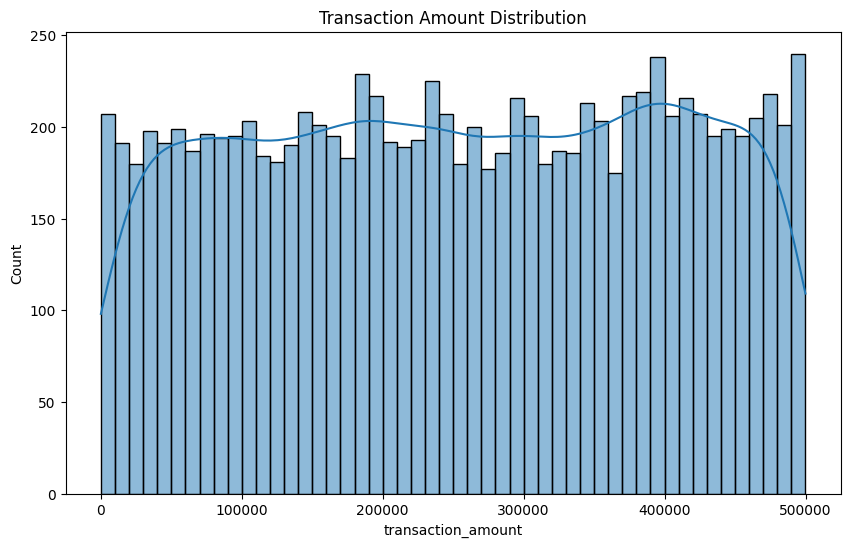

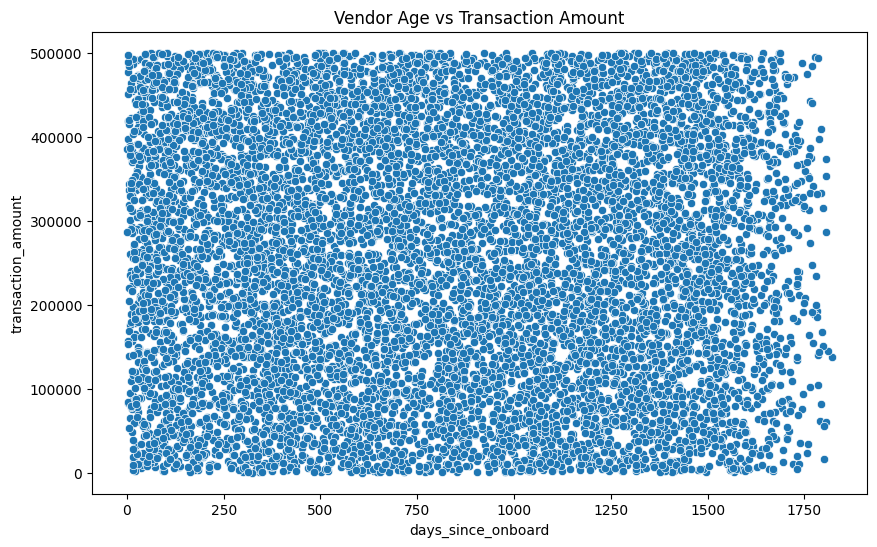

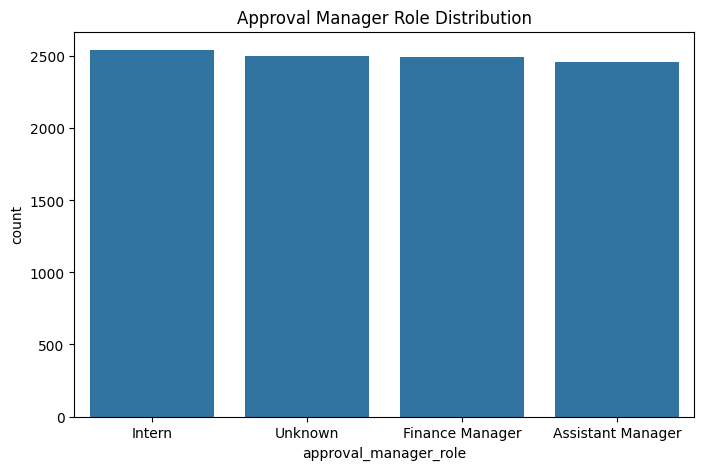

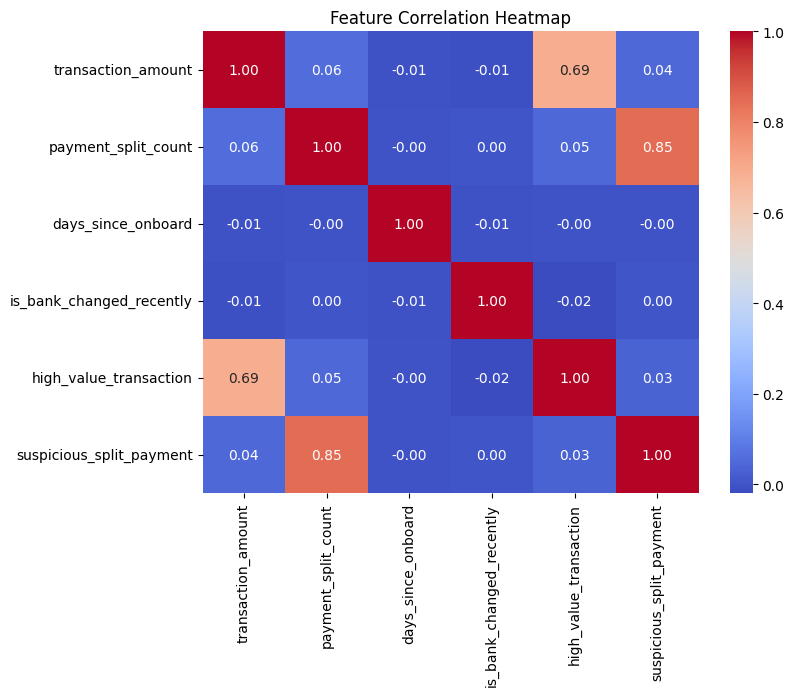

                         transaction_id                             vendor_id  \
0  6a7a891d-ac10-41b5-aafe-e37399cb56cc  31fe3574-6257-41c3-a865-e99abee54096   
1  b617a84b-5f4c-4f39-bf90-b0075c9639c4  0fad6ea1-6483-409e-bfb0-c6efd276ef30   
2  ec58ea3a-49b6-4fb2-9533-65fbe88c18e9  a8910741-4bf3-4a5a-b6ba-4a56e5ff6379   
3  49a36de0-38e6-4055-936b-7e2efffd754c  b9e1d9c3-f8dc-4e46-973e-391093981fc4   
4  86a0acfc-fc2b-4cc3-9e22-d12770bbbccc  35a608da-ee17-462a-aeb2-6917097bf798   

   transaction_amount transaction_date vendor_onboard_date  \
0           344214.39       2024-08-31          2023-08-21   
1           374268.83       2024-09-23          2022-02-20   
2           470418.52       2024-07-01          2023-03-05   
3           232530.79       2024-06-13          2021-07-29   
4           462123.02       2025-03-02          2023-02-19   

  vendor_bank_change_date  payment_split_count approval_manager_role  \
0              2023-10-18                    3                Intern

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset['transaction_amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='days_since_onboard', y='transaction_amount', data=dataset)
plt.title('Vendor Age vs Transaction Amount')
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='approval_manager_role', data=dataset)
plt.title('Approval Manager Role Distribution')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(dataset.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

print(dataset.head())

In [17]:
def improved_generate_transaction_data(num_samples=10000):
    transactions = []
    
    for _ in range(num_samples):
        transaction_id = fake.uuid4()
        vendor_id = fake.uuid4()
        transaction_amount = round(random.uniform(100, 500000), 2)
        transaction_date = fake.date_between(start_date='-1y', end_date='today')
        vendor_onboard_date = fake.date_between(start_date='-5y', end_date=transaction_date)
        
        # Introduce random bank account changes (10% chance)
        vendor_bank_change_date = (vendor_onboard_date + timedelta(days=random.randint(1, 100))) \
                                 if random.random() < 0.1 else None
        
        payment_split_count = random.choice([1, 2, 3, 5, 10]) if transaction_amount > 10000 else 1
        approval_manager_role = random.choice(["Finance Manager", "Assistant Manager", "Unknown", "Intern"])
        
        transactions.append({
            "transaction_id": transaction_id,
            "vendor_id": vendor_id,
            "transaction_amount": transaction_amount,
            "transaction_date": transaction_date,
            "vendor_onboard_date": vendor_onboard_date,
            "vendor_bank_change_date": vendor_bank_change_date,
            "payment_split_count": payment_split_count,
            "approval_manager_role": approval_manager_role
        })
    
    df = pd.DataFrame(transactions)

    # Feature Engineering
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    df['vendor_onboard_date'] = pd.to_datetime(df['vendor_onboard_date'])
    df['days_since_onboard'] = (df['transaction_date'] - df['vendor_onboard_date']).dt.days
    df['is_bank_changed_recently'] = df['vendor_bank_change_date'].notna().astype(int)
    df['high_value_transaction'] = (df['transaction_amount'] > 100000).astype(int)
    df['suspicious_split_payment'] = (df['payment_split_count'] > 3).astype(int)

    # Encode 'approval_manager_role' using ordinal encoding
    role_mapping = {"Intern": 1, "Unknown": 2, "Assistant Manager": 3, "Finance Manager": 4}
    df['approval_manager_role_encoded'] = df['approval_manager_role'].map(role_mapping)

    # New Feature Engineering
    df['vendor_age_category'] = pd.cut(df['days_since_onboard'], bins=[0, 30, 90, 365, 1825],
                                       labels=['<30 days', '30-90 days', '3-12 months', '1-5 years'])
    df['risk_flag'] = ((df['is_bank_changed_recently'] == 1) & (df['days_since_onboard'] < 90)).astype(int)

    return df

In [18]:
dataset2 = improved_generate_transaction_data()

In [40]:
for col in dataset2.select_dtypes(include=['category', 'object']).columns:
    if dataset2[col].dtype.name == 'category' and 'Unknown' not in dataset2[col].cat.categories:
        dataset2[col] = dataset2[col].cat.add_categories(['Unknown']).fillna('Unknown')
    else:
        dataset2[col].fillna('Unknown', inplace=True)

dataset2 = dataset2[dataset2['transaction_amount'] < 500000]  # Removing extreme outliers


/var/folders/0m/l397lmq961z3h8417zx843y80000gp/T/ipykernel_37823/904458061.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset2[col].fillna('Unknown', inplace=True)


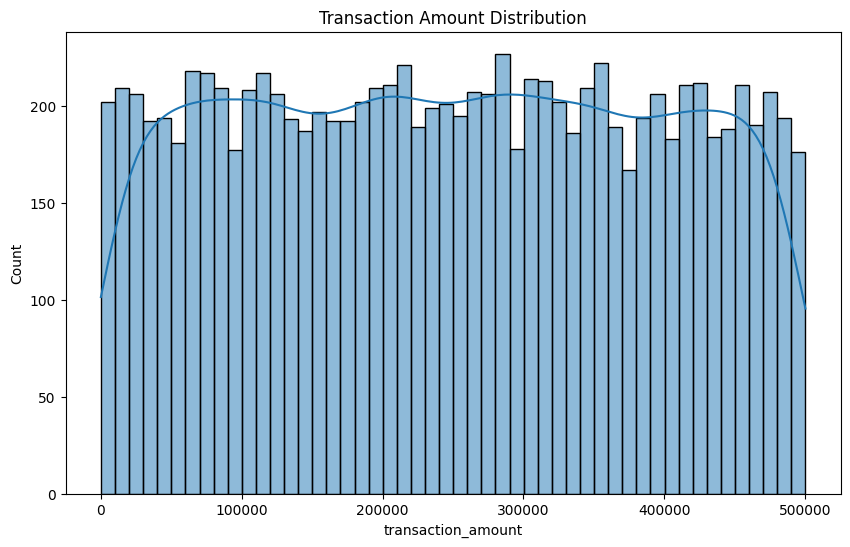

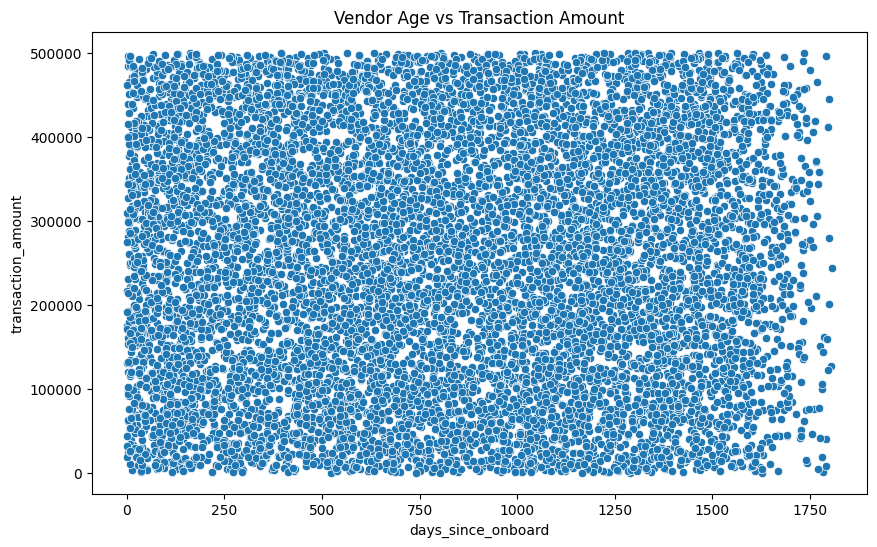

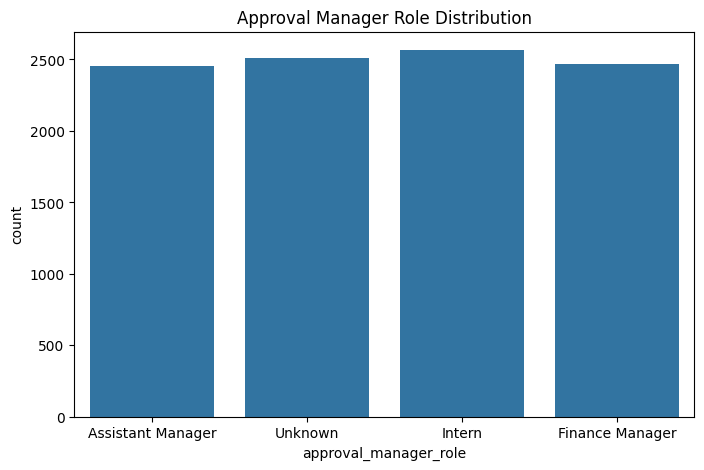

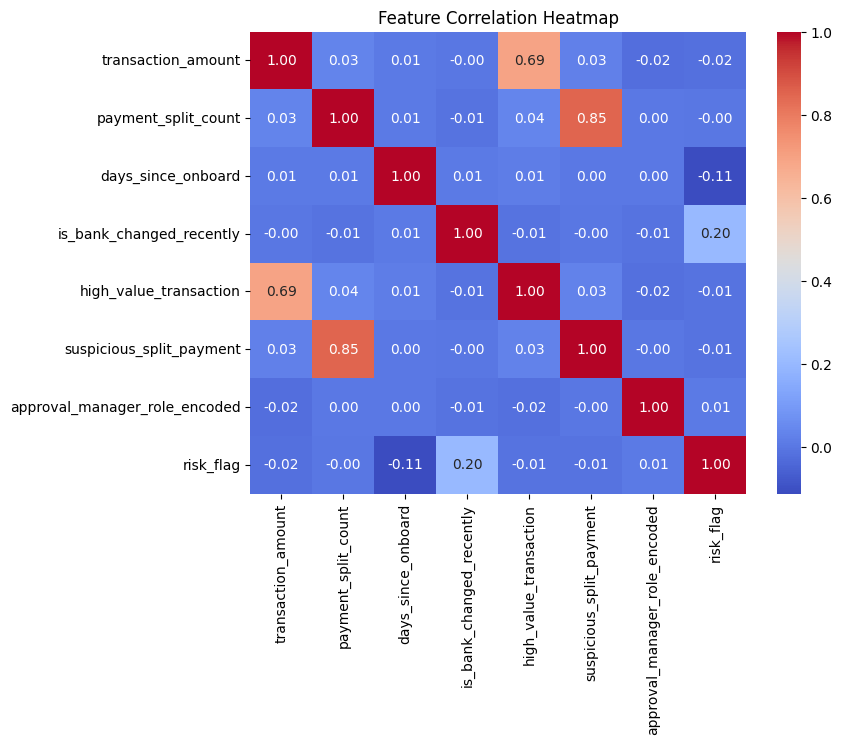

                         transaction_id                             vendor_id  \
0  aeb1d947-7a2e-4d32-99bb-98909d4a809e  07786285-e565-4962-8063-b6d69f026e38   
1  e852acff-5ff3-4857-9c9f-03d7058feb36  23180f02-3b5a-40b4-8a8a-7349c778578c   
2  e32d74c1-1617-42b6-87a7-be2588e87dc7  227a5109-69cf-48fe-8025-65cc31afd7e2   
3  1f714c4e-bf41-4071-84f3-5439aa72322f  e4bd6bfb-d8cc-4ff7-99c9-4d8cdda74f7d   
4  b58e6cdb-77ed-4027-a92a-00c5d443c5e0  c83d253b-cd52-48b8-8a98-a810f75cfb57   

   transaction_amount transaction_date vendor_onboard_date  \
0           154066.63       2024-08-18          2024-04-03   
1           478544.82       2025-01-14          2024-12-17   
2           498049.13       2024-08-09          2021-09-13   
3            43548.48       2024-11-15          2023-08-20   
4           390391.64       2024-06-29          2021-09-18   

  vendor_bank_change_date  payment_split_count approval_manager_role  \
0                    None                    1     Assistant Manager

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset2['transaction_amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='days_since_onboard', y='transaction_amount', data=dataset2)
plt.title('Vendor Age vs Transaction Amount')
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='approval_manager_role', data=dataset2)
plt.title('Approval Manager Role Distribution')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(dataset2.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

print(dataset2.head())


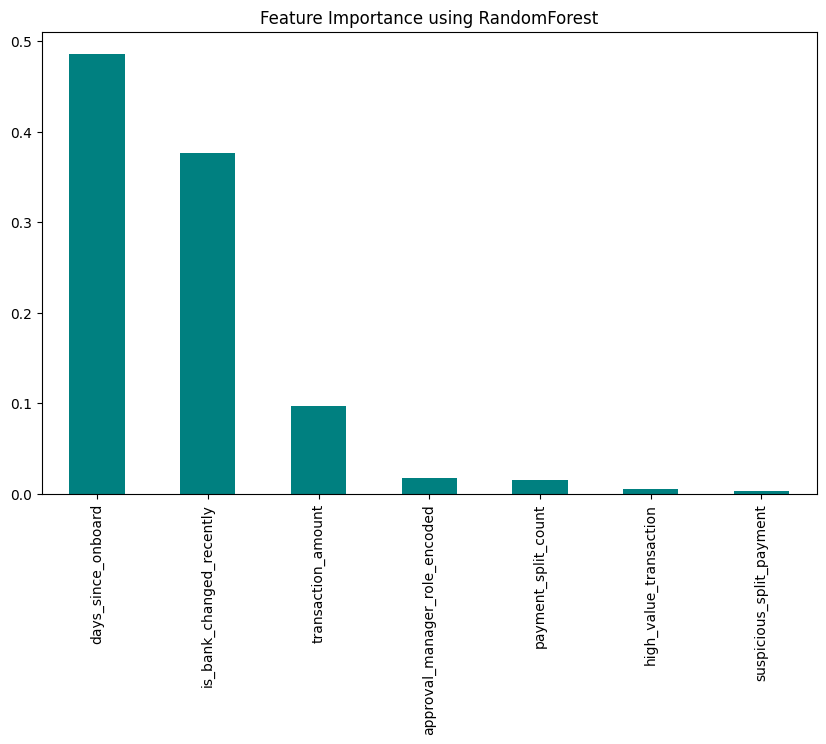

In [30]:
# Feature Importance Analysis
feature_columns = [
    'transaction_amount', 'payment_split_count', 'days_since_onboard',
    'is_bank_changed_recently', 'high_value_transaction',
    'suspicious_split_payment', 'approval_manager_role_encoded'
]
X = dataset2[feature_columns]
y = dataset2['risk_flag']

# Train RandomForest model for feature importance
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Visualizing Feature Importance
plt.figure(figsize=(10, 6))
importance = pd.Series(model.feature_importances_, index=feature_columns).sort_values(ascending=False)
importance.plot(kind='bar', color='teal')
plt.title('Feature Importance using RandomForest')
plt.show()

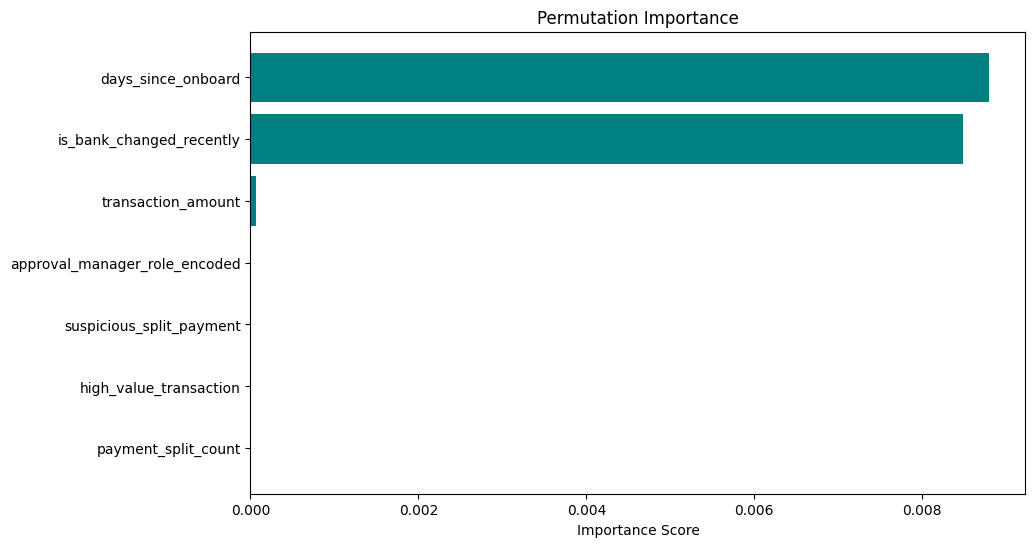

In [31]:
from sklearn.inspection import permutation_importance

# Permutation Importance Analysis
perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)

# Visualizing Permutation Importance
plt.figure(figsize=(10, 6))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='teal')
plt.title('Permutation Importance')
plt.xlabel('Importance Score')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2984
           1       1.00      0.88      0.93        16

    accuracy                           1.00      3000
   macro avg       1.00      0.94      0.97      3000
weighted avg       1.00      1.00      1.00      3000

ROC-AUC Score: 1.0


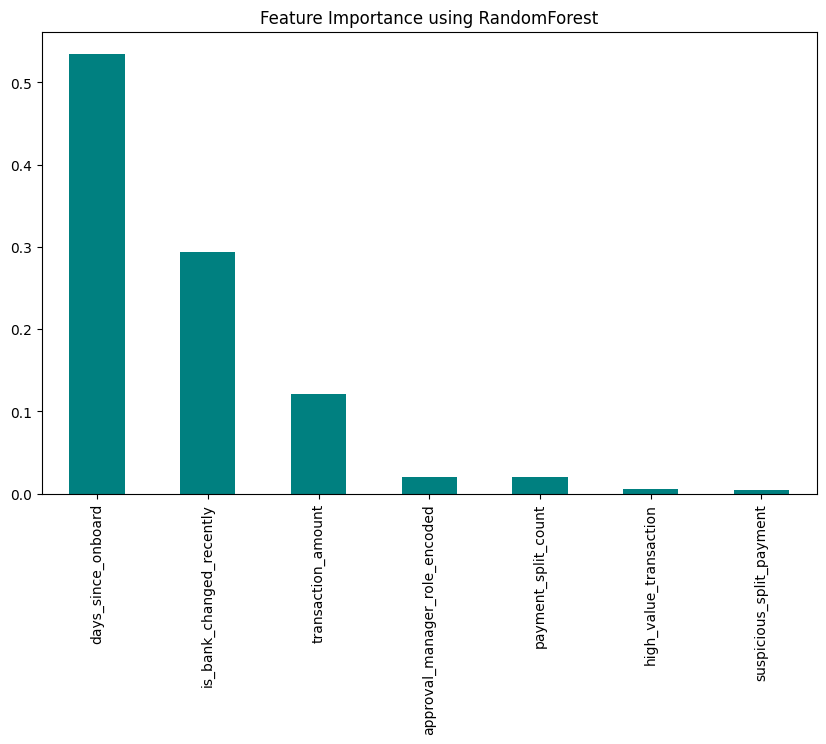

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train RandomForest model for feature importance
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# Visualizing Feature Importance
plt.figure(figsize=(10, 6))
importance = pd.Series(model.feature_importances_, index=feature_columns).sort_values(ascending=False)
importance.plot(kind='bar', color='teal')
plt.title('Feature Importance using RandomForest')
plt.show()


Stratified K-Fold ROC-AUC Scores: [1. 1. 1. 1. 1.]
Mean ROC-AUC Score: 1.0000


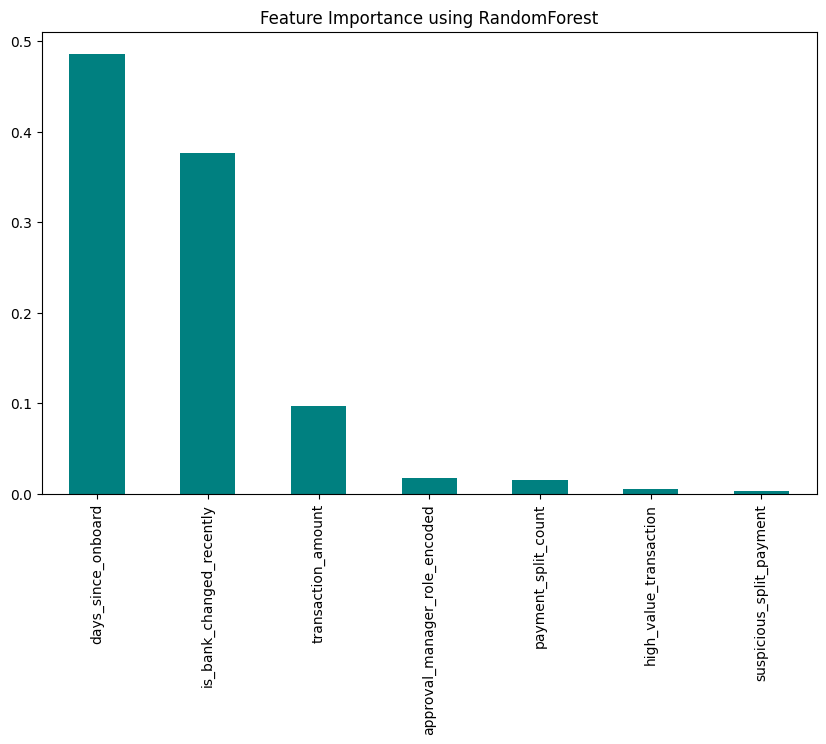

In [42]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=skf, scoring='roc_auc')

print(f"Stratified K-Fold ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC-AUC Score: {np.mean(cv_scores):.4f}")

rf_model.fit(X, y)

plt.figure(figsize=(10, 6))
importance = pd.Series(rf_model.feature_importances_, index=feature_columns).sort_values(ascending=False)
importance.plot(kind='bar', color='teal')
plt.title('Feature Importance using RandomForest')
plt.show()
